In [11]:
import os
import cv2
import numpy as np

def load_data():
  base_folder = 'iNaturalist'
  toxic_folder = f'{base_folder}/toxic_images'
  nontoxic_folder = f'{base_folder}/nontoxic_images'

  toxic_paths = [os.path.join(dp, f) for dp, dn, filenames  in os.walk(toxic_folder) for f in filenames if os.path.splitext(f)[1] == '.jpg']
  nontoxic_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(nontoxic_folder) for f in filenames if os.path.splitext(f)[1] == '.jpg']

  toxic_imgs = [cv2.imread(path) for path in toxic_paths]
  nontoxic_imgs = [cv2.imread(path) for path in nontoxic_paths]

  return toxic_imgs, nontoxic_imgs

data = load_data()


In [12]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers, models

In [13]:
toxic_imgs, nontoxic_imgs = data
IMG_SHAPE = (224, 224, 3)
prepared_toxic_imgs = np.array([cv2.resize(img, IMG_SHAPE[:2]) for img in toxic_imgs])
prepared_nontoxic_imgs = np.array([cv2.resize(img, IMG_SHAPE[:2]) for img in nontoxic_imgs])

print(prepared_toxic_imgs.shape)
print(prepared_nontoxic_imgs.shape)

(1645, 224, 224, 3)
(1815, 224, 224, 3)


In [14]:
toxic_labels = np.array([[1, 0] for _ in range(len(prepared_toxic_imgs))])
nontoxic_labels = np.array([[0, 1] for _ in range(len(prepared_nontoxic_imgs))])

X = np.vstack((prepared_toxic_imgs, prepared_nontoxic_imgs))
y = np.vstack((toxic_labels, nontoxic_labels))

X, y = shuffle(X, y, random_state=42)
y = np.argmax(y, axis=1)

# Split the data into temporary and testing (combined test/validation) sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.105, random_state=42)

# Split the temporary set into the actual test and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.12, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)


(2724, 224, 224, 3) (2724,) (364, 224, 224, 3) (364,) (372, 224, 224, 3) (372,)


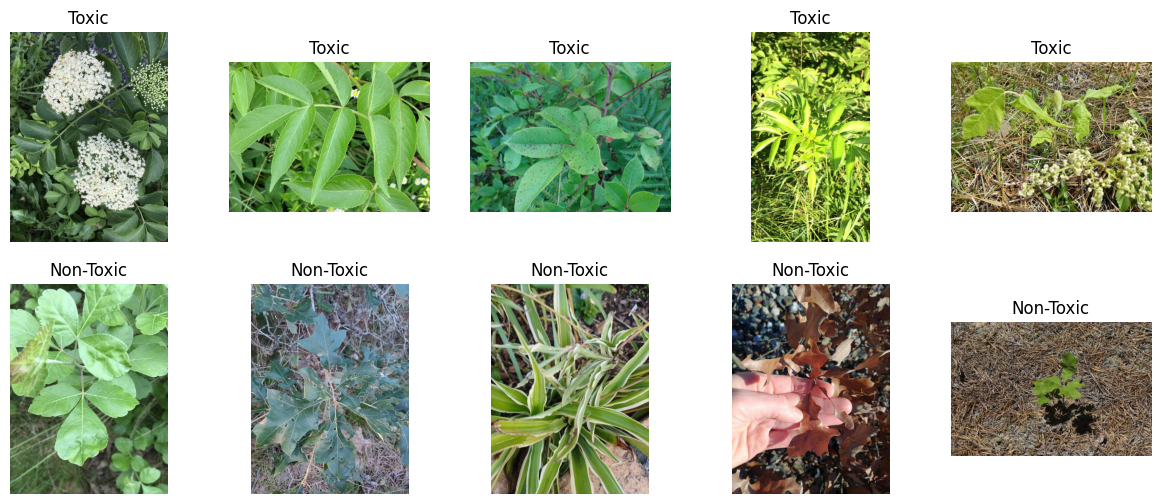

In [15]:
import random
import matplotlib.pyplot as plt

def display_random_images(toxic_imgs, nontoxic_imgs, num_toxic=5, num_nontoxic=5):
    random_toxic_imgs = random.sample(toxic_imgs, num_toxic)
    random_nontoxic_imgs = random.sample(nontoxic_imgs, num_nontoxic)

    plt.figure(figsize=(15, 6))

    for i, img in enumerate(random_toxic_imgs):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Toxic')
        plt.axis('off')

    for i, img in enumerate(random_nontoxic_imgs):
        plt.subplot(2, 5, num_toxic + i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Non-Toxic')
        plt.axis('off')

    plt.show()

# Use the function to display 5 toxic and 5 non-toxic images
display_random_images(toxic_imgs, nontoxic_imgs, num_toxic=5, num_nontoxic=5)


In [ ]:
# Define the CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to feed into dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Add dropout for regularization

model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Use ImageDataGenerator for data augmentation and loading images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Callback to save weights of the best model based on validation accuracy
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/cnn1/',  # Specify the path where you want to save the weights
    save_weights_only=True,
    save_best_only=True,  
    monitor='val_accuracy',  
    mode='max',  
    verbose=1  
)

history_c1 = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print('Test accuracy:', test_acc)


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

for layer in base_model.layers:
    layer.trainable = False

2023-12-03 17:39:15.840941: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-03 17:39:15.840972: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-03 17:39:15.840977: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-03 17:39:15.841075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-03 17:39:15.841316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
import platform

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, adjust if needed

if platform.system() == "Darwin" and platform.processor() == "arm":
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
else:
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Callback to save weights of the best model based on validation accuracy
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p1_virginia/',  # Specify the path where you want to save the weights
    save_weights_only=True,
    save_best_only=True,  
    monitor='val_accuracy',  
    mode='max',  
    verbose=1  
)

history_transfer_p1 = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/20


2023-12-03 17:39:20.712633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 0.7193 - accuracy: 0.6538

2023-12-03 17:39:28.995457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.70430, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p1_virginia/
86/86 [==============================] - 12s 113ms/step - loss: 0.7193 - accuracy: 0.6538 - val_loss: 0.5702 - val_accuracy: 0.7043
Epoch 2/20
85/86 [============================>.] - ETA: 0s - loss: 0.5558 - accuracy: 0.7305
Epoch 2: val_accuracy improved from 0.70430 to 0.77688, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p1_virginia/
86/86 [==============================] - 8s 94ms/step - loss: 0.5557 - accuracy: 0.7305 - val_loss: 0.4994 - val_accuracy: 0.7769
Epoch 3/20
85/86 [============================>.] - ETA: 0s - loss: 0.4883 - accuracy: 0.7636
Epoch 3: val_accuracy improved from 0.77688 to 0.77957, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p1_virginia/
86/86 [==============================] - 8s 94ms/step - loss

In [9]:
eval_result = model.evaluate(X_test, y_test)
print(f"Test loss: {eval_result[0]}, Test accuracy: {eval_result[1]}")

12/12 [==============================] - 2s 130ms/step - loss: 0.4161 - accuracy: 0.8077
Test loss: 0.41606467962265015, Test accuracy: 0.807692289352417


In [10]:
model.load_weights('/Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p1_virginia/')

# PAUSE

In [11]:
# Unfreeze the top N layers of the base model
N = 15
for layer in model.layers[0].layers[-N:]:
    layer.trainable = True


if platform.system() == "Darwin" and platform.processor() == "arm":
    opt_2 = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
else:
    opt_2 = tf.keras.optimizers.Adam(learning_rate=0.00001)


# Compile the model with a lower learning rate
model.compile(optimizer=opt_2, loss='binary_crossentropy', metrics=['accuracy'])

# Callback to save weights of the best model based on validation accuracy
checkpoint_callback_finetune = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p2_virginia/',  # Specify the path where you want to save the weights
    save_weights_only=True,
    save_best_only=True,  
    monitor='val_accuracy',  
    mode='max',  
    verbose=1  
)

# Fine-tune the model
history_transfer_p2 = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint_callback_finetune])

Epoch 1/10


2023-12-03 17:44:12.424967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.8653

2023-12-03 17:44:22.246084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.81989, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p2_virginia/
86/86 [==============================] - 14s 133ms/step - loss: 0.2995 - accuracy: 0.8653 - val_loss: 0.4672 - val_accuracy: 0.8199
Epoch 2/10
85/86 [============================>.] - ETA: 0s - loss: 0.2450 - accuracy: 0.8956
Epoch 2: val_accuracy improved from 0.81989 to 0.82527, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p2_virginia/
86/86 [==============================] - 9s 106ms/step - loss: 0.2447 - accuracy: 0.8957 - val_loss: 0.4622 - val_accuracy: 0.8253
Epoch 3/10
85/86 [============================>.] - ETA: 0s - loss: 0.1989 - accuracy: 0.9224
Epoch 3: val_accuracy did not improve from 0.82527
86/86 [==============================] - 8s 98ms/step - loss: 0.1987 - accuracy: 0.9225 - val_loss: 0.4497 - val_accuracy: 0.8199
Epoch 4/10
85/86 [========================

In [12]:
model.load_weights('/Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/transfer_p2_virginia/')

In [13]:
eval_result = model.evaluate(X_test, y_test)
print(f"Test loss: {eval_result[0]}, Test accuracy: {eval_result[1]}")

12/12 [==============================] - 1s 126ms/step - loss: 0.4212 - accuracy: 0.8104
Test loss: 0.4211902320384979, Test accuracy: 0.8104395866394043


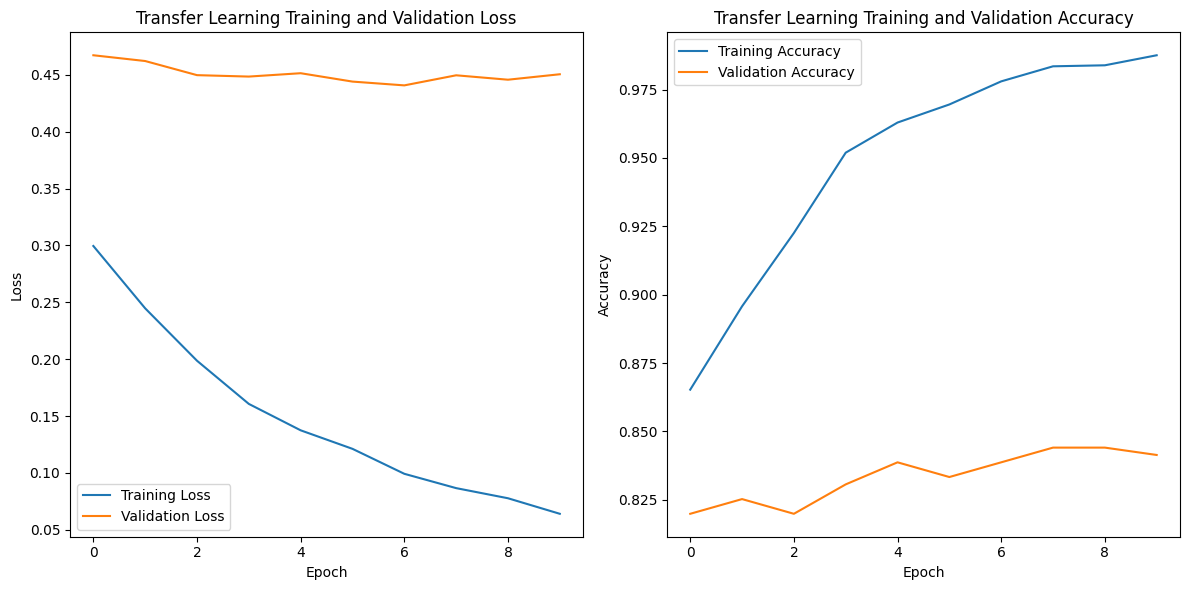

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_transfer_p2.history['loss'], label='Training Loss')
plt.plot(history_transfer_p2.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_transfer_p2.history['accuracy'], label='Training Accuracy')
plt.plot(history_transfer_p2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

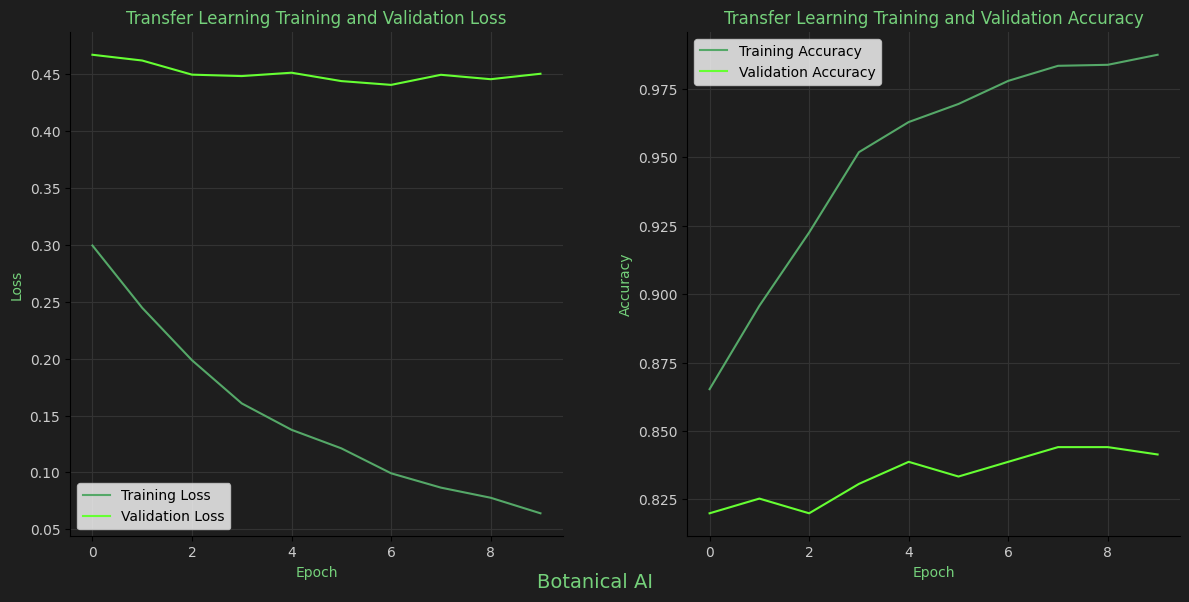

In [24]:
import matplotlib.pyplot as plt

# Set the color palette
green_palette = ['#55a868', '#66ff33', '#6ec886', '#75d17b']

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
axes[0].plot(history_transfer_p2.history['loss'], label='Training Loss', color=green_palette[0])
axes[0].plot(history_transfer_p2.history['val_loss'], label='Validation Loss', color=green_palette[1])
axes[0].set_title('Transfer Learning Training and Validation Loss', color=green_palette[3])
axes[0].set_xlabel('Epoch', color=green_palette[3])
axes[0].set_ylabel('Loss', color=green_palette[3])
axes[0].legend()

# Plot training and validation accuracy with increased contrast
axes[1].plot(history_transfer_p2.history['accuracy'], label='Training Accuracy', color=green_palette[0])
axes[1].plot(history_transfer_p2.history['val_accuracy'], label='Validation Accuracy', color=green_palette[1])  # Adjusted color
axes[1].set_title('Transfer Learning Training and Validation Accuracy', color=green_palette[3])
axes[1].set_xlabel('Epoch', color=green_palette[3])
axes[1].set_ylabel('Accuracy', color=green_palette[3])
axes[1].legend()

# Set background color to dark greyish black
fig.patch.set_facecolor('#1e1e1e')
for ax in axes:
    ax.set_facecolor('#1e1e1e')
    ax.grid(color='#333333')

# Customize tick colors
for tick in axes[0].get_xticklabels() + axes[0].get_yticklabels() + axes[1].get_xticklabels() + axes[1].get_yticklabels():
    tick.set_color('#cccccc')

# Remove spines
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add plant-themed elements
fig.text(0.5, 0.02, 'Botanical AI', ha='center', va='center', color=green_palette[3], fontsize=14)
# fig.text(0.02, 0.5, 'Performance', ha='center', va='center', rotation='vertical', color=green_palette[3], fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout(w_pad=4)

plt.show()


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24112513 (91.98 MB)
Trainable params: 6045185 (23.06 MB)
Non-trainable params: 18067328 (68.92 MB)
_________

In [31]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Define your model
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
